In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, Point
from itertools import chain

import shapely


In [2]:
growth_df = pd.read_pickle("growth_df_clustered.pkl")
growth_df.head()

,months_since_war,-3,-2,-1,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,cluster
17.474949,296.964984,0.001713,0.002960,0.003273,0.000885,0.001020,0.001169,0.005665,0.033146,0.011555,0.038658,...,0.294979,0.256263,0.144956,0.056323,0.014078,0.116878,0.155073,0.154488,0.201556,3
17.480288,295.841260,0.001554,0.002572,0.002647,0.001243,0.001357,0.001396,0.003503,0.039053,0.010267,0.043849,...,0.294930,0.258062,0.129433,0.049293,0.018897,0.130522,0.164956,0.162026,0.214243,3
17.485865,294.717527,0.007369,0.006435,0.005641,0.002180,0.001755,0.003822,0.015460,0.099150,0.054273,0.076929,...,0.297108,0.269469,0.130002,0.055334,0.029291,0.139437,0.161127,0.168939,0.216274,3
17.491679,293.593785,0.006218,0.007969,0.003646,0.001346,0.001417,0.002631,0.007188,0.078115,0.014350,0.056613,...,0.307846,0.274105,0.117155,0.041598,0.007778,0.091717,0.119585,0.155557,0.211258,3
17.497726,292.470032,0.008501,0.017743,0.008738,0.002157,0.002583,0.003510,0.008523,0.066387,0.009337,0.050040,...,0.310948,0.277589,0.124095,0.049967,0.009588,0.080941,0.106471,0.150628,0.211287,3


<AxesSubplot:xlabel='months_since_war'>

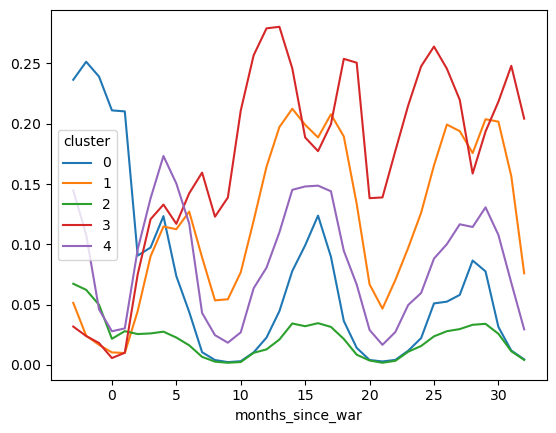

In [3]:
growth_df.groupby("cluster").mean().transpose().plot()


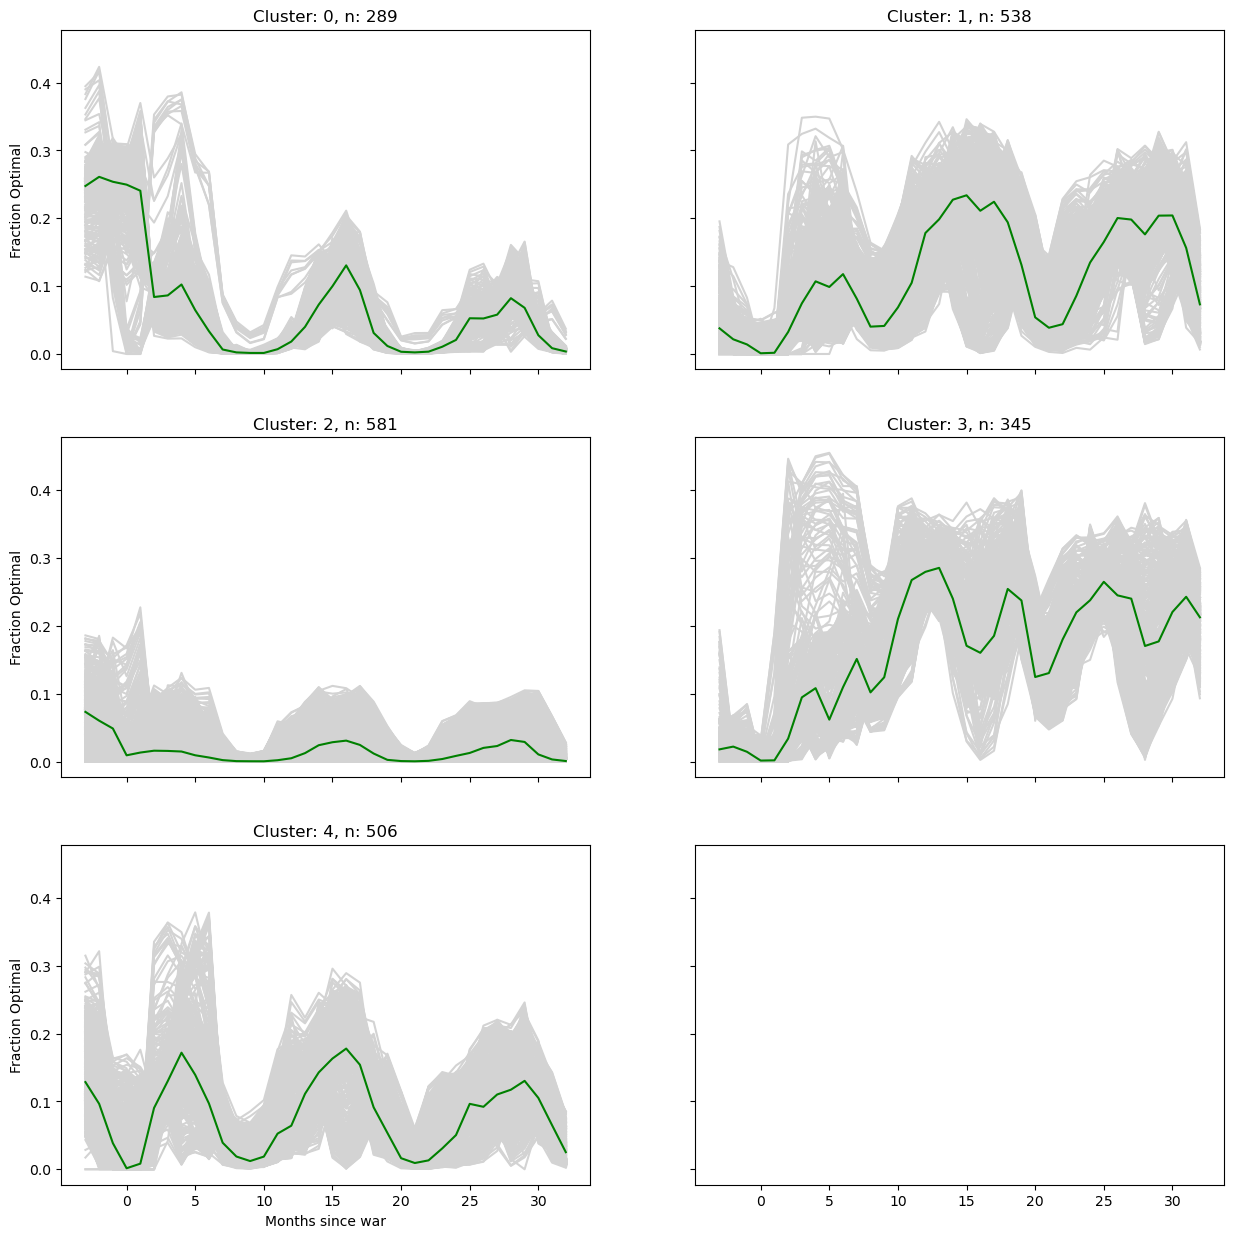

In [4]:
fix, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(15, 15))

axes = axes.flatten()
for cluster, cluster_df in growth_df.groupby("cluster"):
    del(cluster_df["cluster"])
    ax = axes[cluster]
    cluster_df.transpose().plot(ax=ax, color="lightgrey", legend=False)
    cluster_df.median().transpose().plot(ax=ax, color="green", legend=False)
    ax.set_ylabel("Fraction Optimal")
    ax.set_xlabel("Months since war")
    ax.set_title("Cluster: " + str(cluster) + ", n: " + str(cluster_df.shape[0]))

In [5]:
growth_df["latlon"] = growth_df.index
growth_df['latitude'] = growth_df["latlon"].str[0]
growth_df['longitude'] = growth_df['latlon'].str[1]
growth_df['longitude'] = growth_df[growth_df["longitude"]>180]["longitude"] - 360
#print(growth_df.longitude.min())

In [6]:
growth_df["geometry"] = growth_df[['longitude','latitude']].apply(tuple, axis=1)
growth_df["geometry"] = growth_df["geometry"].apply(Point)
growth_df = growth_df[["cluster", "geometry"]]
growth_df = gpd.GeoDataFrame(growth_df)
growth_df

,months_since_war,cluster,geometry
17.474949,296.964984,3,POINT (-63.03502 17.47495)
17.480288,295.841260,3,POINT (-64.15874 17.48029)
17.485865,294.717527,3,POINT (-65.28247 17.48587)
17.491679,293.593785,3,POINT (-66.40622 17.49168)
17.497726,292.470032,3,POINT (-67.52997 17.49773)
...,...,...,...
52.808242,229.511355,2,POINT (-130.48865 52.80824)
52.928145,228.400686,2,POINT (-131.59931 52.92815)
53.342084,229.672963,2,POINT (-130.32704 53.34208)
53.464323,228.563404,2,POINT (-131.43660 53.46432)


In [7]:
buffered = gpd.GeoDataFrame(growth_df.buffer(0.65))
buffered["cluster"] = growth_df["cluster"]
buffered.columns=["geometry", "cluster"]
cluster_dict = {0:"good before, bad during nuclear winter",
               1:"bad before, okay during nuclear winter",
               2:"bad before, bad during nuclear winter",
               3:"bad before, good during nuclear winter",
               4:"okay before, okay during nuclear winter"
               }
buffered["cluster_names"] = buffered["cluster"].map(cluster_dict)


In [8]:
global_map = gpd.read_file("../geospatial_information/world_map/ne_10m_admin_0_countries.shp")


(-130.0, -65.0)

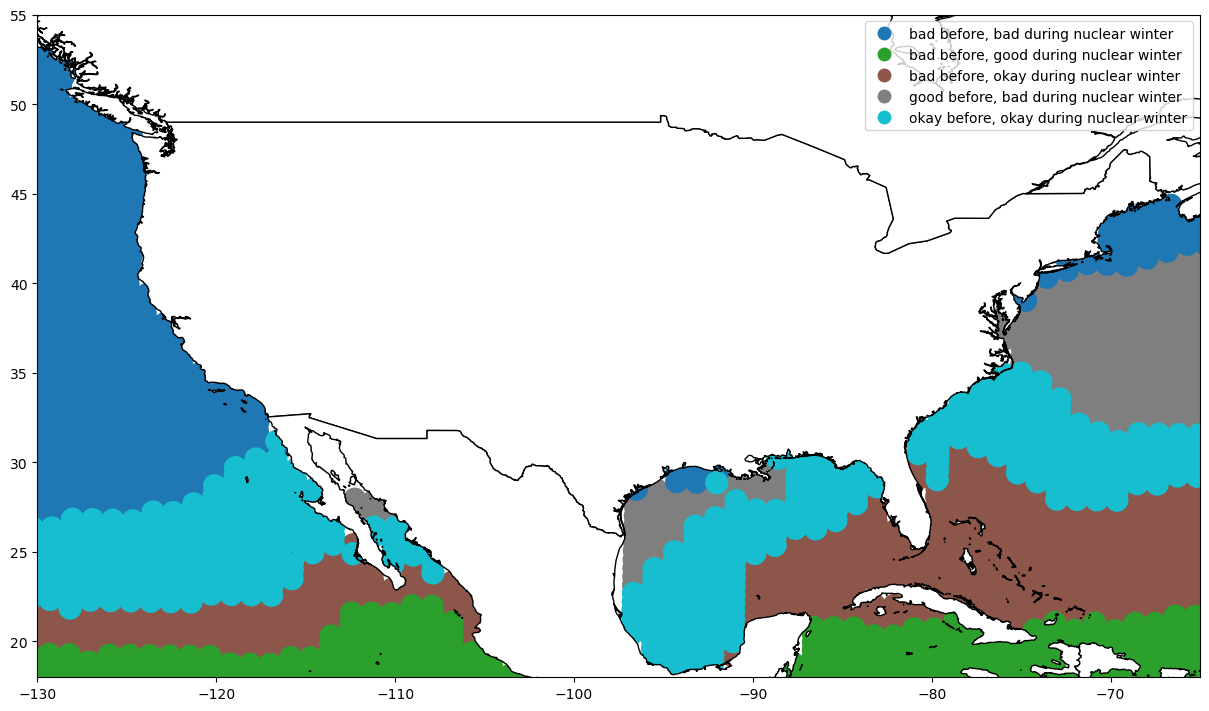

In [9]:
cluster_dissolved = buffered.dissolve(by="cluster")
cluster_dissolved.set_crs(epsg=4326,inplace=True)
cluster_dissolved.to_crs(global_map.crs,inplace=True)
cluster_dissolved["cluster"] = cluster_dissolved.index
ax = cluster_dissolved.plot(column="cluster_names", legend=True)
fig = plt.gcf()
fig.set_size_inches(15,15)
global_map.plot(ax=ax, color="white", edgecolor="black")
ax.set_ylim(18,55)
ax.set_xlim(-130,-65)

In [10]:
import os
os.getcwd()

'/home/florian/Documents/GitHub/Seaweed-Growth-Model/data/interim_results'